In [2]:
import numpy as np
import pandas as pd  
from numpy import newaxis
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import scikitplot as skplt
#import xgboost as xgb
import seaborn as seabornInstance 
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')

# Baseline 

In [44]:
import numpy as np
T=10
n_sim=10000
buyout=100
buy_year=5
r=0.05#risk free risk
price_0=25#oil price
price_sigma=0.15
opex_0=10.2
opex_sigma=0.1
quant=np.array([9, 7.7, 6.5, 5.5, 4.7, 4, 3.4, 2.9, 2.5, 2.1])
capex=5
rng = np.random.RandomState(1)


# price matrix and opex matrix
price = np.c_[np.ones((n_sim, 1))*price_0, np.empty([n_sim, T - 1])]
opex = np.c_[np.ones((n_sim, 1))*opex_0, np.empty([n_sim, T - 1])]

# simulate prices (GBM) and opex 
for t in np.arange(1,T):
    price[:, t] = price[:, t - 1] * np.exp(-0.5*(price_sigma**2)*1 + 
                                           price_sigma*rng.randn(n_sim).T)
    
    opex[:, t] = opex[:, t - 1] * np.exp(0.02-0.5*((opex_sigma)**2)*1 +
                                            opex_sigma*rng.randn(n_sim).T)


rev_gross = quant*price
cost = quant*opex
rev_net = rev_gross-cost-capex
net_cf = rev_net * 3/4
dis_fact = np.array([(1 + r)**(-i - 1) for i in range(T)])

# net present value of cash flows
npv = (net_cf * dis_fact).sum(axis=1)

# net present value of cash flows in years 6-10
npv_cont = (net_cf[:, buy_year:] * dis_fact[buy_year:]).sum(axis=1)

# put together regressor matrix with price and opex in buyout year
X_price = price[:, buy_year]
X_opex = opex[:, buy_year]
X = np.c_[X_price, X_opex]

In [45]:
Y = npv_cont[..., newaxis]

train_X = X[500:]
test_X = X[:500]
train_Y = Y[500:]
test_Y = Y[:500]

print("Traing data size: ", train_X.shape)
print("Testing data size: ", test_X.shape)

algorithmName = []
trainingAccList = []
testingAccList = []
mseList = []

Traing data size:  (9500, 2)
Testing data size:  (500, 2)


In [46]:
# define model I am using for regression
lr = LinearRegression()

# training process
lr.fit(train_X, train_Y)

algorithmName.append("LR")

In [47]:
cv_pred_lr = lr.predict(test_X)

mse = mean_squared_error(test_Y, cv_pred_lr)
mseList.append(mse)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse*(1/2.0)))

MSE: 822.16
RMSE: 411.08


In [48]:
# if estimated continuation value < buyout price, sell
# if estimated continuation value > buyout price, don't sell
max_val = []
results=[]
for i in cv_pred_lr:
    if i<100:
        max_val.append(100)
    elif 100<i<120:
        max_val.append(i)
    else:
        max_val.append(i-40+(i/3-40))
# expected NPV with option

enpv_w_opt = ((net_cf[:, :buy_year] * dis_fact[:buy_year]).sum(axis=1)).mean(axis=0) + np.mean(max_val,axis=0)+capex
# expected NPV without the option
enpv_wo_opt = npv.mean(axis=0) 
opt_val = enpv_w_opt - enpv_wo_opt

print ("The ENPV of the project without the option is $%.1f" % enpv_wo_opt)
print ("The ENPV of the project with the option is $%.1f" % enpv_w_opt)
print ("The value of the option to sell in year %s is $%.1f" % (buy_year, opt_val))

The ENPV of the project without the option is $390.7
The ENPV of the project with the option is $420.3
The value of the option to sell in year 5 is $29.6


# Nested Monte carlo Simulation 

In [50]:
T=5
N_sim=100
rng = np.random.RandomState(1)
Lists=[]
for i in range(len(X_price)):
    price = np.c_[np.ones((N_sim, 1))*X_price[i], np.empty([N_sim, T - 1])]
    for t in np.arange(1,T):
        price[:, t] = price[:, t - 1] * np.exp(-0.5*(price_sigma**2)*1 + 
                                           price_sigma*rng.randn(N_sim).T)
    Lists.append(price)

In [51]:
price2=np.array(Lists)

In [52]:
T=5
N_sim=100
rng = np.random.RandomState(1)
copy=[]
for i in range(len(X_price)):
    opex = np.c_[np.ones((N_sim, 1))*X_opex[i], np.empty([N_sim, T - 1])]
    for t in np.arange(1,T):
        opex[:, t] = opex[:, t - 1] * np.exp(-0.5*(opex_sigma**2)*1 + 
                                           opex_sigma*rng.randn(N_sim).T)
    copy.append(opex)

In [53]:
opex2=np.array(copy)

In [54]:
quant2=np.array([4, 3.4, 2.9, 2.5, 2.1])
rev_gross2 = quant2*price2
cost2 = quant2*opex2
rev_net2 = rev_gross2-cost2-capex
net_cf2 = rev_net2 * 3/4
dis_fact2 = np.array([0.7462154 , 0.71068133, 0.67683936, 0.64460892, 0.61391325])

npv_cont2 = net_cf2 * dis_fact2

In [55]:
npv_cont3=npv_cont2.mean(1).sum(axis=1)

In [63]:
# if estimated continuation value < buyout price, sell
# if estimated continuation value > buyout price, don't sell
max_val = []
results=[]
for i in test_Y:
    if i<100:
        max_val.append(100)
    elif 100<i<120:
        max_val.append(i)
    else:
        max_val.append(i-40+(i/3-40))
# expected NPV with option
enpv_w_opt = ((net_cf[:, :buy_year] * dis_fact[:buy_year]).sum(axis=1)).mean(axis=0) + np.mean(max_val,axis=0)+capex 
# expected NPV without the option
enpv_wo_opt = npv.mean(axis=0) 
opt_val = enpv_w_opt - enpv_wo_opt

print ("The ENPV of the project without the option is $%.1f" % enpv_wo_opt)
print ("The ENPV of the project with the option is $%.1f" % enpv_w_opt)
print ("The value of the option to sell in year %s is $%.1f" % (buy_year, opt_val))

The ENPV of the project without the option is $390.7
The ENPV of the project with the option is $424.1
The value of the option to sell in year 5 is $33.4


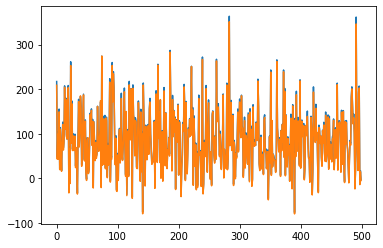

In [57]:
plt.plot(npv_cont3[:500])
plt.plot(cv_pred_lr)
#plt.plot(test_Y)

In [58]:
npv_cont3[:500].shape

(500,)

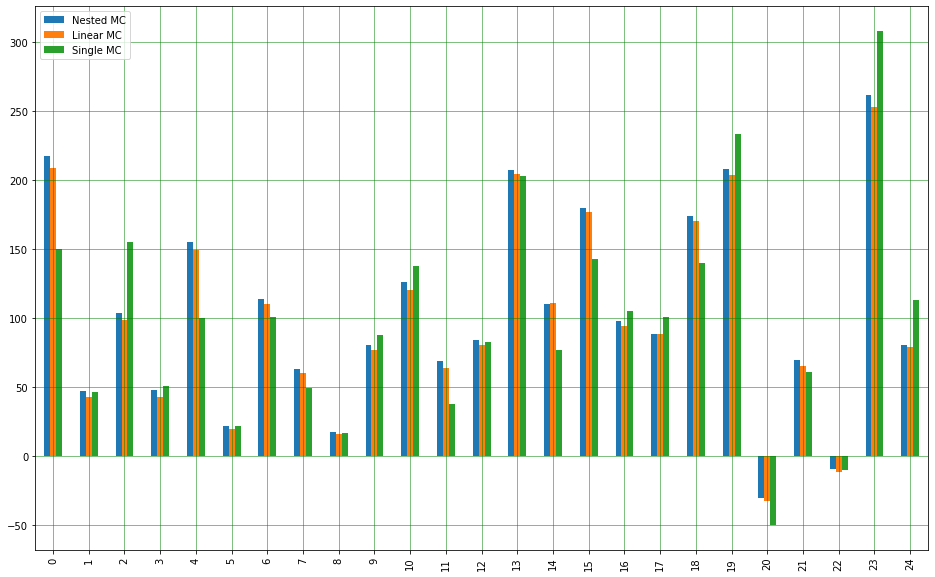

In [62]:
#   creating dataframe of actual vs predicted values
df = pd.DataFrame({'Nested MC': npv_cont3[:500].flatten(), 'Linear MC': cv_pred_lr.flatten(),'Single MC':test_Y.flatten()})
#   plotting actual vs predicted values
df1 = df.head(25)
#style = 'dark_background'
df1.plot(kind='bar',figsize=(16,10))
#plt.style.use(style)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()